In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
Sigma1 = np.array([[1, 0], [0, 1]])
mu1 = np.array([1, 1])
Sigma2 = np.array([[6, 0], [0, 6]])
mu2 = np.array([6, 6])

In [3]:
Sigma1 = np.array([[3, 0], [0, 3]])
mu1 = np.array([3, 5])
Sigma2 = np.array([[1, 0], [0, 1]])
mu2 = np.array([10, 5])

In [87]:
from sklearn.datasets import make_blobs

n_samples = 300
n_cls = 2

X,y = make_blobs( 
        n_samples=n_samples,
        centers=[mu1, mu2],  
        cluster_std=[1, 2.45]#[[3, 3], [1, 1]]
    )


lmbd = [ 1.1, ]*n_cls  # коэффициент "цены" ошибки

X.shape, y.shape

((300, 2), (300,))

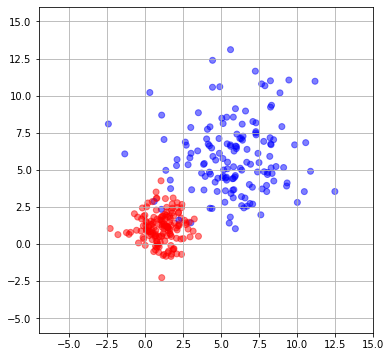

In [88]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 15)
plt.ylim(-6, 16)
plt.scatter(X[:,0], X[:,1], c = [['r','b','g','y'][j] for j in y], alpha=0.5 )   
plt.grid()
plt.show()

In [89]:
from sklearn.naive_bayes import GaussianNB

In [90]:
clf = GaussianNB().fit(X, y)

In [91]:
y_pred = clf.predict(X)

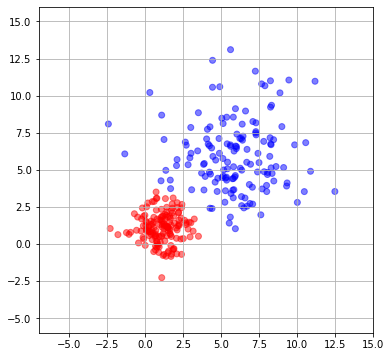

In [92]:
plt.figure(figsize=(6, 6))
plt.xlim(-7, 15)
plt.ylim(-6, 16)
plt.scatter(X[:,0], X[:,1], c = [['r','b','g','y'][j] for j in y_pred], alpha=0.5 )   
plt.grid()
plt.show()

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, )

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((150, 2), (150,), (150, 2), (150,))

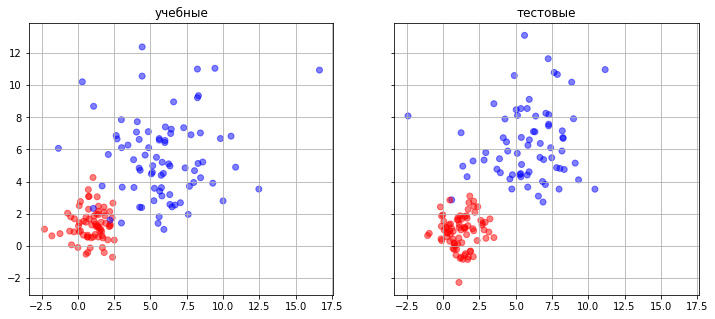

In [94]:
def plot_data(ax,X,y,t, marker='o'):
    c = [ ['r','b','g','y'][j] for j in y  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5, marker=marker )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [118]:
def K(x): return (1.0 - x**2) * 0.75

In [135]:
def K(x): return 0.5 * (abs(x) < 1)

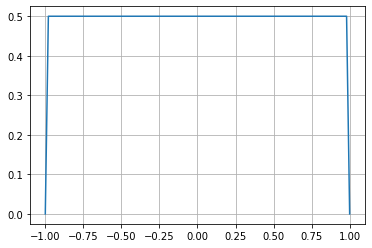

In [136]:
x = np.linspace(-1,1,100)
plt.plot(x,K(x))
plt.grid()
plt.show()

In [120]:
# евклидова метрика
def rho(x1,x2): return np.sqrt( np.square(x1-x2).sum(axis=1) )

$ a(x) = \underset{y\in Y}{\operatorname{argmax}} \left[ \lambda_y P_y \frac{1}{l_y} \underset{i:y=y_i}{\sum} K\left(\frac{\rho(x-x_i)}{h}\right) \right] $

In [121]:
def bayes_score(X,Xl,yl,lmbd_n,h,n,Py_n,ly_n): # скор принадлежности X к классу n
    # Xl,yl - учебный набор
    # Py_n - априорная вероятность класса n
    # ly_n - количество объектов в классе n
    # lmbd_n - цена ошибки класса n
    # h - ширина парзеновского окна
    
    Xn = Xl[yl==n,:] # точки класса n

    # для каждой точки набора X
    # считаем растояние до всех точек учебного класса
    r = np.asarray([ rho(X[i,:],Xn) for i in range(X.shape[0]) ]) 
    
    # применяем ядро и суммируем
    r = K( r / h).sum(axis=1)

    return ( Py_n * lmbd_n / ly_n ) * r

In [122]:
def bayes(X,Xl,yl,lmbd,h): # байесовский классификатор
    # для кажной точки набора X 
    # хаходим номер класса с наибольшим скором
    # Xl,yl - учебный набор
    # lmbd - цена ошибки классов    
    # h - ширина окна
    
    # количество объектов в классах
    ly = np.asarray([ (yl==c).sum() for c in sorted(set(yl)) ])
    Py = ly/ly.sum() # априорные вероятности классов
    
    return np.argmax( 
        np.asarray([ 
            bayes_score(X,Xl,yl,lmbd[n],h,n,Py[n],ly[n])  
            for n in sorted(set(yl)) 
        ]),
        axis=0 )

In [123]:
# LOO ( leave one out) - скользящий контроль,
# выбираем объект учебного набора X,y
# удаляем его из набора
# выполняем его классификацию и проверяем ответ
def loo(X,y,lmbd,h):
    er = 0 # количество ошибок
    for i in range(X.shape[0]):
        xi,yi = X[i,:].reshape(1,X.shape[1]),y[i] # выбираем объект учебного набора
        # удаляем его из набора
        Xl,yl = np.delete(X, i, axis=0), np.delete(y, i, axis=0)
        er += int(bayes(xi,Xl,yl,lmbd,h) != yi) # выполняем классификацию и проверяем ответ

    return er

In [133]:
# подбираем параметр ширины парзеновского окна 
er = { loo(X_train,y_train,lmbd,h) : h   for h in range(5,0,-1) }
h = er[min(er)]

In [134]:
er

{13: 4, 14: 1}

In [126]:
h

4

In [140]:
o = bayes(X_test,X_train,y_train,lmbd,h)

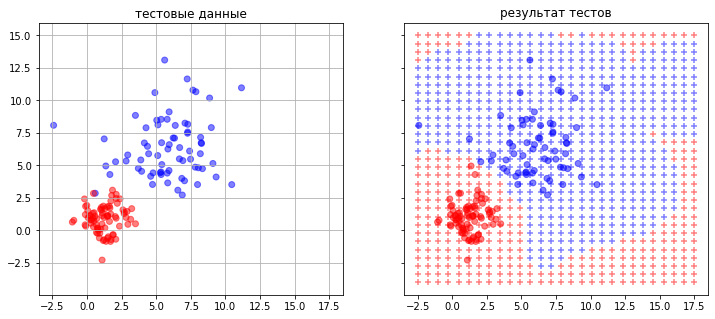

In [141]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y_test,'тестовые данные')    
plot_data(ax1,X_test,o,'результат тестов')  
plot_data(ax1,X_grid,y_grid,'результат тестов', marker='+')    
plt.show()

In [137]:
xlim = (-2.5, 17.5)
ylim = (-4, 15)
dist = 0.25

In [138]:
x2, y2 = np.meshgrid(np.linspace(xlim[0], xlim[1], round(xlim[1] - xlim[0] / dist)), np.linspace(ylim[0], ylim[1], round(ylim[1] - ylim[0] / dist)))
X_grid = np.hstack([x2.reshape(-1, 1), y2.reshape(-1, 1)])

In [64]:
X_grid = (np.linspace(-2, 12, 140).reshape(-1, 1).repeat(140, axis=1) + np.linspace(-3, 11, 140).reshape(1, -1).repeat(140, axis=0)).reshape(-1, 2)
y_grid = bayes(X_grid, X_train, y_train, lmbd, h)

In [52]:
X_grid.shape

(80, 2)

In [75]:
n_dots = 16 * 2 + 1

In [76]:
x1 = np.linspace(-2, 14, n_dots).reshape(-1, 1).repeat(n_dots, axis=1).reshape(-1, 1)
x1

array([[-2.],
       [-2.],
       [-2.],
       ...,
       [14.],
       [14.],
       [14.]])

In [77]:
x2 = np.linspace(-2, 14, n_dots).reshape(1, -1).repeat(n_dots, axis=0).reshape(-1, 1)
x2

array([[-2. ],
       [-1.5],
       [-1. ],
       ...,
       [13. ],
       [13.5],
       [14. ]])

In [78]:
X_grid = np.hstack([x1, x2])

In [79]:
X_grid.shape

(1089, 2)

In [139]:
y_grid = bayes(X_grid, X_train, y_train, lmbd, h)